# 大数据分析与机器智能（ME237） 第四次作业
分值：5分

评分标准：代码完成度。仅完善（*）标记的代码块即可。 

提交说明：将本文件上传至canvas。

截止日期：4月27日 23:59

### 完善个人信息（*）

In [1]:
student_name = '史枢洋'
student_id = '519021910397'

## 导入需要使用的包

In [1]:
import pandas as pd
import numpy as np

## 从零开始实现决策树算法（*）
教材算法5.2和算法5.3其实是有漏洞的，下述代码对该漏洞进行了补充，尝试找一下下面的代码比书上的算法多了什么？可以写在最后的反馈里。

In [20]:
class DecisionTreeClassifier:
    def __init__(self, feature_names=None, method='info_gain', threshold=0.0):
        """
        决策树。根据method选择的不同可以使用ID3算法和C4.5算法。

        :param feature_names: 制定决策树划分所设计的特征名。
        :param method: info_gain(ID3算法)或者info_gain_ratio(C4.5算法)
        :param threshold: 停止生长的阈值
        """
        self.feature_names = feature_names
        self.method = method
        self.threshold = threshold
        self.tree = {}

    # 熵
    @staticmethod
    def entropy(y: np.ndarray):
        N = len(y)
        count = []
        for value in set(y):
            count.append(len(y[y == value]))
        count = np.array(count)
        entro = -np.sum((count / N) * (np.log2(count / N)))
        return entro

    def cond_entropy(self, X: np.ndarray, y: np.ndarray, cond: int):
        """
        计算条件熵。

        :param X: 特征数据
        :param y: 标签数据
        :param cond: 条件的索引,例如1表示第一列数据
        :return: 条件熵
        """
        x = X[:,cond]
        cond_entro = 0
        for value_x in set(x):
            prob_x = len(x[x==value_x])/len(x)
            entro = 0
            for value_y in set(y):
                count = 0
                for ind in range(0,len(x)):
                    if (x[ind]==value_x) and (y[ind]==value_y):
                        count = count+1
                probyx = count/len(x[x==value_x])
                if probyx == 0:
                    entro = 0
                else:
                    entro = entro - probyx*np.log2(probyx)
            cond_entro = cond_entro + prob_x*entro
        return cond_entro

    def info_gain(self, X: np.ndarray, y: np.ndarray, cond: int):
        """
        计算信息增益。

        :param X: 特征数据
        :param y: 标签数据
        :param cond: 条件的索引,例如1表示第一列数据
        :return: 信息增益
        """
        result = self.entropy(y) - self.cond_entropy(X, y, cond)
        return result

    def info_gain_ratio(self, X: np.ndarray, y: np.ndarray, cond: int):
        """
        计算信息增益比。

        :param X: 特征数据
        :param y: 标签数据
        :param cond: 条件的索引,例如1表示第一列数据
        :return: 信息增益比
        """
        result = self.info_gain(X,y,cond)/self.entropy(X[:,cond])
        return result

    def best_split(self, X: np.ndarray, y: np.ndarray):
        """根据method指定的方法使用信息增益或信息增益比来计算各个维度的最大信息增益(比),返回特征的axis"""
        _, M = X.shape
        info_gains = []
        if self.method == 'info_gain':
            split = self.info_gain
        elif self.method == 'info_gain_ratio':
            split = self.info_gain_ratio
        else:
            raise NameError('指定的方法{}不在可接受的范围内。可接受的参数有info_gain以及info_gain_ratio'.format(self.method))
        for i in range(M):
            tmp_gain = split(X, y, i)
            info_gains.append(tmp_gain)
        if max(info_gains) < self.threshold:
            return 'STOP'
        best_feature = np.argmax(info_gains)
        return best_feature

    @staticmethod
    def majority_count(y):
        """返回类别数最多的类别"""
        unique, counts = np.unique(y, return_counts=True)
        max_idx = np.argmax(counts)
        return unique[max_idx]

    def fit(self, X, y):
        """
        训练模型。

        :param X: 特征数据
        :param y: 标签数据
        :return: 无
        """
        self.tree = self._train_decision_tree(X, y, self.feature_names)

    def _train_decision_tree(self, X: np.ndarray, y: np.ndarray, feature_names: list):
        """
        训练决策（子）树。

        :param X: 特征数据
        :param y: 标签数据
        :param feature_names: 特征名
        :return: （子）决策树
        """
        feature_names = feature_names.copy()
        M, N = X.shape
        if len(np.unique(y)) == 1:  # 如果已经得到了完全一样的结果，不必细分了
            return y[0]

        X_feature_unique = [len(set(X[:, i])) for i in range(N)]
        if len(set(X_feature_unique)) == 1 and 1 in X_feature_unique:  # 如果X已经没有区分度了，也不必细分了
            return self.majority_count(y)

        if N == 0:  # 如果可以用的特征已经分完了，不必继续了
            return self.majority_count(y)

        best_split_index = self.best_split(X, y)
        if best_split_index == 'STOP':  # 达到阈值，不再细分
            return self.majority_count(y)

        best_feature_label = feature_names[best_split_index]
        tree = {best_feature_label: {}}
        del (feature_names[best_split_index])

        feature_values = np.unique(X[:, best_split_index])
        for val in feature_values:
            idx = np.where(X[:, best_split_index] == val)
            sub_X = np.delete(X, best_split_index, axis=1)[idx]
            sub_y = y[idx]
            sub_labels = feature_names
            tree[best_feature_label][val] = self._train_decision_tree(sub_X, sub_y, sub_labels)  # 递归求解
        return tree

    def predict(self, X: np.ndarray):
        """
        预测模型。

        :param X: 特征数据
        :return: 预测结果
        """
        y = []
        for x in X:
            y.append(self._decision_tree_predict_instance(list(x), self.tree, self.feature_names))
        return np.array(y)

    def _decision_tree_predict_instance(self, x: list, tree: dict, feature_names: list):
        """
        预测单个实例结果。

        :param x: 实例数据,list
        :param tree: 决策(子）树
        :param feature_names: 特征标签
        :return: 单个实例预测结果
        """
        if isinstance(tree, np.int64):  # 如果根节点就是叶节点的话
            return tree
        x = x.copy()
        feature_names = feature_names.copy()
        current_label = list(tree.keys())[0]
        idx = feature_names.index(current_label)
        feature_value = x[idx]
        if feature_value not in tree[current_label].keys():
            return 0  # 在测试集上碰到了没有见过的类型，就预测训练集上比例比较大的
        sub_tree = tree[current_label][feature_value]
        if isinstance(sub_tree, np.int64):
            return sub_tree
        else:
            x.pop(idx)
            feature_names.pop(idx)
            result = self._decision_tree_predict_instance(x, sub_tree, feature_names)
        return result

## 应用决策树模型
在Titanic数据集上，使用建立决策树模型，对乘客生存进行预测。模型需在训练集（train.csv）上训练后，对测试集（test.csv）进行预测，仿照gender_submission.csv格式输出预测结果。

数据集相关的介绍参见作业3。

### 数据读取与预处理

In [21]:
# **如有需要，本部分内容可以进行更改**
def class_age(x):
    if x < 25:
        return 1
    elif x < 50:
        return 2
    else:
        return 3


def data_preprocessing(_data):
    # 对缺失值进行填充
    age_average = _data['Age'].mean()
    _data['Age'].fillna(age_average, inplace=True)
    _data['Embarked'].fillna('N', inplace=True)
    # 将连续值进行切段
    _data['Age'] = _data['Age'].apply(lambda x: class_age(x))
    # 将文本替换为数字
    data_encode = {'Sex': {'male': 0, 'female': 1}, 'Embarked': {'C': 0, 'S': 1, 'Q': 2, 'N': 3}}
    for column, column_code in data_encode.items():
        _data[column] = _data[column].apply(lambda x: column_code[x])
    return _data


# 数据读取
train_data = pd.read_csv('train.csv')

# 数据预处理
train_data = data_preprocessing(train_data)

target = 'Survived'

### 确定模型参数并训练模型（*）
模型有三个参数需要同学们确定，分别是feature_names（使用的特征），method（方法）以及threshold（阈值）。同学们需要对训练集进行进一步划分，通过验证集上的结果对method及threshold两个参数进行确定。

**参数值可以通过设计代码自动计算获得，也可以是设计实验改变参数重复实验后记录结果然后选取。如果选择第二种方法，需要将实验结果截图后粘贴在下方。直接给出参数的取值会被扣分。如有需要feature_names也可调整。**

提示：sklearn包里面的一些方法例如train_test_split可以使用

In [22]:
# 模型参数
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
method = 'info_gain_ratio'
# method = 'info_gain'
threshold = 0.05
X_train, y_train = train_data[features].values, train_data[target].values
my_tree = DecisionTreeClassifier(feature_names=features, method=method, threshold=threshold)
my_tree.fit(X_train, y_train)

### 在训练集上进行预测

In [23]:
test_data = pd.read_csv('test.csv')
test_data = data_preprocessing(test_data)
X_test = test_data[features].values
y_test_predict = my_tree.predict(X_test)
test_data['Survived'] = y_test_predict
test_data[['PassengerId', 'Survived']].to_csv('test_predict.csv', index=False)

### 提交预测结果（*）
将生成的test_predict.csv文件提交至[kaggle网站](https://www.kaggle.com/competitions/titanic/submit)，查看自身排名。双击本文本块进入编辑模式后，ctrl+v将个人成绩排名截图粘贴至此。例如：

![rank.png](rank.png)
Kaggle成绩前10的同学将会在群里进行表扬，并有机会获得小礼物。没有kaggle成绩不扣分。
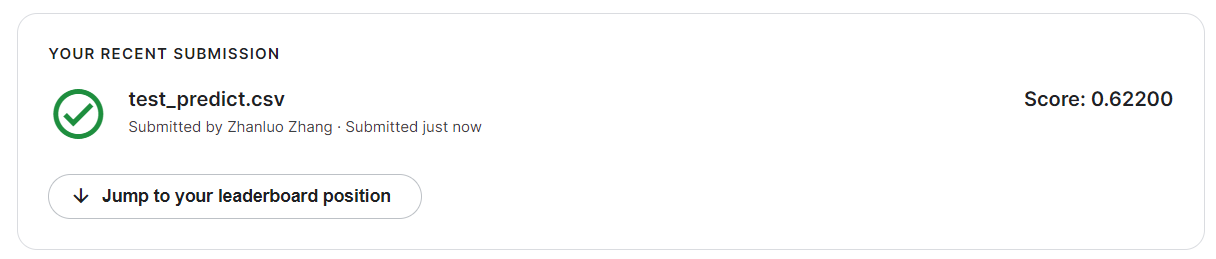

## 作业调查（*）

In [ ]:
kaggle_score = 0.77511  # 提交到kaggle网站后给出的准确度，注意不是最佳成绩。
time_used = 1  # 本次作业花费的时间，单位小时
difficulty_assessment = 4  # 作业难度评价，1为非常简单，10为非常困难
feedback = '本次作业需要自行动手编程的地方较少,但决策树生成代码值得细致理解'  # 对本次作业或者课堂内容的反馈，任何想说的话